In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
!pip install h5py boto3 matplotlib numpy opencv-python
# !pip install -q tensorflow-addons

In [13]:

import boto3
from botocore.handlers import disable_signing
import os

# S3 client with anonymous access
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

bucket = s3.Bucket('sevir')
prefix = 'data/'

# Create directory to store files
os.makedirs('sevir_data', exist_ok=True)

# # List available .h5 files
# for obj in bucket.objects.filter(Prefix=prefix):
#     if obj.key.endswith('.h5'):
#         print(obj.key)

In [15]:
import os
import boto3
from botocore.handlers import disable_signing

#  anonymously connecting to SEVIR S3 bucket
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket = s3.Bucket('sevir')

# removing existing files 
def clear_folder(folder_path):
    if not os.path.exists(folder_path):
        return
    for f in os.listdir(folder_path):
        file_path = os.path.join(folder_path, f)
        os.remove(file_path)
    print(f" Cleared folder: {folder_path}")
    
def down_ir107():
    prefix = 'data/ir107/'
    local_folder = 'SEVIR_data/ir107'
    os.makedirs(local_folder, exist_ok=True)
    
    for obj in bucket.objects.filter(Prefix=prefix):
        if obj.key.endswith('.h5'):
            filename = os.path.basename(obj.key)
            local_path = os.path.join(local_folder, filename)
            size_mb = obj.size / (1024 * 1024)
            print(f"Downloading {filename} ({size_mb:.2f} MB)...")
            bucket.download_file(obj.key, local_path)
            break  
            
# clear_folder('SEVIR_data/ir107')

down_ir107()

print("\n Done")


 Cleared folder: SEVIR_data/ir107

 Done


In [17]:
import h5py
import numpy as np

# file_path = '/content/SEVIR_data/ir107/SEVIR_IR107_RANDOMEVENTS_2018_0101_0430.h5' ==>for colab
file_path = '/kaggle/working/SEVIR_data/ir107/SEVIR_IR107_RANDOMEVENTS_2018_0101_0430.h5'

with h5py.File(file_path, 'r') as f:
    print("Top-level keys:", list(f.keys()))
    data = f['ir107'][:]  # Load entire ir107 dataset into memory

# Transpose to (event, time, height, width) => (553, 49, 192, 192)
data = data.transpose(0, 3, 1, 2)
print("Transposed shape:", data.shape)


Top-level keys: ['id', 'ir107']
Transposed shape: (553, 49, 192, 192)


In [7]:
# with h5py.File(file_path, 'r') as f:
#     def plot_event(sequence):
#         def normalize(frame):
#             return np.clip((frame - 180) / (300 - 180), 0, 1)
#         plt.figure(figsize=(15, 3))
#         for i, idx in enumerate([0, 8, 16, 24, 32, 40, 48]):
#             norm_frame = normalize(sequence[idx])
#             plt.subplot(1, 7, i + 1)
#             plt.imshow(norm_frame, cmap='inferno')
#             plt.title(f'Frame {idx}')
#             plt.axis('off')
#         plt.tight_layout()
#         plt.show()

#     for i in range(10):
#         print(f"🌀 Event {i}")
#         plot_event(f['ir107'][i])

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gc

def simple_memory_efficient_preprocessing(data):
    """Simplified preprocessing that won't crash your notebook"""
    print(f"Input data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Temperature range: [{data.min():.1f}, {data.max():.1f}] K")
    
    # Memory management
    gc.collect()
    
    # Simple normalization
    def normalize(frames):
        return np.clip((frames - 180) / (300 - 180), 0, 1)
    
    # Simple activity check
    def has_activity(x, threshold=0.01):
        return np.var(x) > threshold
    
    X_inputs, Y_outputs = [], []
    
    for i, event in enumerate(data):
        if i % 50 == 0:
            print(f"Processing event {i}/{len(data)}")
            gc.collect()  # Force garbage collection every 50 events
        
        try:
            # Normalize
            norm_event = normalize(event.astype(np.float32))
            
            # Create single sequence (no overlapping to save memory)
            if norm_event.shape[0] >= 18:
                input_seq = norm_event[:12]      # First 12 frames
                target_seq = norm_event[12:18]   # Next 6 frames
                
                # Check activity
                if has_activity(input_seq) and has_activity(target_seq):
                    X_inputs.append(input_seq)
                    Y_outputs.append(target_seq)
        except Exception as e:
            print(f"Error processing event {i}: {e}")
            continue
    
    # Convert to arrays with memory management
    X_inputs = np.array(X_inputs, dtype=np.float32)
    Y_outputs = np.array(Y_outputs, dtype=np.float32)
    
    print(f"✅ Preprocessing complete!")
    print(f"Valid sequences: {len(X_inputs)}")
    print(f"Input shape: {X_inputs.shape}")
    print(f"Output shape: {Y_outputs.shape}")
    print(f"Memory usage: {(X_inputs.nbytes + Y_outputs.nbytes) / 1e9:.2f} GB")
    
    # train/val split
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_inputs, Y_outputs, test_size=0.2, random_state=42
    )
    
    # Add channel dimension: (N, T, H, W, 1)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    Y_train = Y_train[..., np.newaxis]
    Y_val = Y_val[..., np.newaxis]
    
    print(f"\n📊 Data Split Summary:")
    print(f"Train: {X_train.shape[0]} samples")
    print(f"Val:   {X_val.shape[0]} samples")
    print(f"Final shapes: X{X_train.shape}, Y{Y_train.shape}")
    
    # Final memory cleanup
    del X_inputs, Y_outputs
    gc.collect()
    
    return X_train, X_val, Y_train, Y_val

# Memory management settings
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Limit TensorFlow memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# preprocessing
X_train, X_val, Y_train, Y_val = simple_memory_efficient_preprocessing(data)


Input data shape: (553, 49, 192, 192)
Data type: int16
Temperature range: [-32768.0, 4590.0] K
Processing event 0/553
Processing event 50/553
Processing event 100/553
Processing event 150/553
Processing event 200/553
Processing event 250/553
Processing event 300/553
Processing event 350/553
Processing event 400/553
Processing event 450/553
Processing event 500/553
Processing event 550/553
✅ Preprocessing complete!
Valid sequences: 259
Input shape: (259, 12, 192, 192)
Output shape: (259, 6, 192, 192)
Memory usage: 0.69 GB

📊 Data Split Summary:
Train: 207 samples
Val:   52 samples
Final shapes: X(207, 12, 192, 192, 1), Y(207, 6, 192, 192, 1)


In [17]:
# (X_train, X_val, X_test), (Y_train, Y_val, Y_test) = main_preprocessing_pipeline(data)

In [66]:
import os
# Disable XLA and layout optimizer
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np

# Disable eager execution issues
tf.config.run_functions_eagerly(False)

# Enhanced constants
L2_REG = 2e-5
DROPOUT_RATE = 0.25

# FIXED: Simplified attention layer that doesn't create variables dynamically
def simple_attention_block(x):
    """Simplified attention that doesn't create variables during call"""
    # Channel attention using built-in layers only
    channels = x.shape[-1]
    
    # Global pooling
    avg_pool = layers.GlobalAveragePooling3D()(x)
    max_pool = layers.GlobalMaxPooling3D()(x)
    
    # Channel attention
    avg_out = layers.Dense(channels // 8, activation='relu')(avg_pool)
    avg_out = layers.Dense(channels, activation='sigmoid')(avg_out)
    avg_out = layers.Reshape((1, 1, 1, channels))(avg_out)
    
    max_out = layers.Dense(channels // 8, activation='relu')(max_pool)
    max_out = layers.Dense(channels, activation='sigmoid')(max_out)
    max_out = layers.Reshape((1, 1, 1, channels))(max_out)
    
    # Combine attention
    channel_attention = layers.Add()([avg_out, max_out])
    x_attended = layers.Multiply()([x, channel_attention])
    
    return x_attended

# Simplified residual block without dynamic variable creation
def stable_residual_block(x, filters, kernel_regularizer=None, dropout_rate=0.0):
    """Stable residual block without dynamic variable creation"""
    shortcut = x
    
    # First convolution
    x = layers.Conv3D(filters, (3, 3, 3), padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation('relu')(x)
    
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    
    # Second convolution
    x = layers.Conv3D(filters, (3, 3, 3), padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    
    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, (1, 1, 1), padding='same', kernel_regularizer=kernel_regularizer)(shortcut)
        shortcut = layers.BatchNormalization(momentum=0.9)(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    
    # Apply simplified attention
    x = simple_attention_block(x)
    
    return x

# Simplified decoder block
def stable_decoder_block(x, skip, filters, kernel_regularizer=None, dropout_rate=0.0):
    """Stable decoder without dynamic variable creation"""
    # Upsampling
    x = layers.Conv3DTranspose(filters, (3, 3, 3), strides=(1, 2, 2), 
                              padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation('relu')(x)
    
    # Process skip connection
    skip_processed = layers.Conv3D(filters, (1, 1, 1), padding='same', kernel_regularizer=kernel_regularizer)(skip)
    skip_processed = layers.BatchNormalization(momentum=0.9)(skip_processed)
    skip_processed = layers.Activation('relu')(skip_processed)
    
    # Concatenate and process
    combined = layers.Concatenate()([x, skip_processed])
    x = stable_residual_block(combined, filters, kernel_regularizer, dropout_rate)
    
    return x

def build_stable_detail_model(input_shape=(12, 192, 192, 1)):
    """Stable detail model without dynamic variable creation"""
    inputs = Input(shape=input_shape)
    
    # Encoder
    e1 = stable_residual_block(inputs, 32, l2(L2_REG), DROPOUT_RATE * 0.2)
    p1 = layers.MaxPooling3D((1, 2, 2))(e1)
    
    e2 = stable_residual_block(p1, 64, l2(L2_REG), DROPOUT_RATE * 0.3)
    p2 = layers.MaxPooling3D((1, 2, 2))(e2)
    
    e3 = stable_residual_block(p2, 128, l2(L2_REG), DROPOUT_RATE * 0.4)
    p3 = layers.MaxPooling3D((1, 2, 2))(e3)
    
    # Bottleneck with ConvLSTM
    b = layers.Reshape((12, 24, 24, 128))(p3)
    b = layers.ConvLSTM2D(256, (3, 3), padding='same', return_sequences=True,
                          activation='relu', kernel_regularizer=l2(L2_REG),
                          dropout=0.2, recurrent_dropout=0.2)(b)
    b = layers.BatchNormalization(momentum=0.9)(b)
    b = layers.Dropout(DROPOUT_RATE * 0.3)(b)
    b = layers.Reshape((12, 24, 24, 256))(b)
    
    # Decoder
    d1 = stable_decoder_block(b, e3, 128, l2(L2_REG), DROPOUT_RATE * 0.4)
    d2 = stable_decoder_block(d1, e2, 64, l2(L2_REG), DROPOUT_RATE * 0.3)
    d3 = stable_decoder_block(d2, e1, 32, l2(L2_REG), DROPOUT_RATE * 0.2)
    
    # Output
    output_conv = layers.Conv3D(1, (1, 1, 1), padding='same', activation='sigmoid')(d3)
    outputs = layers.Lambda(lambda t: t[:, -6:, :, :, :])(output_conv)
    
    return models.Model(inputs, outputs)

# Stable loss functions
def stable_dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Stable Dice coefficient without dynamic variable creation"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Handle shape mismatch
    if len(y_true.shape) == 4 and len(y_pred.shape) == 5:
        y_true = tf.expand_dims(y_true, axis=-1)
    elif len(y_pred.shape) == 4 and len(y_true.shape) == 5:
        y_pred = tf.expand_dims(y_pred, axis=-1)
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def stable_combined_loss(y_true, y_pred):
    """Stable combined loss without dynamic variable creation"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Handle shape mismatch
    if len(y_true.shape) == 4 and len(y_pred.shape) == 5:
        y_true = tf.expand_dims(y_true, axis=-1)
    elif len(y_pred.shape) == 4 and len(y_true.shape) == 5:
        y_pred = tf.expand_dims(y_pred, axis=-1)
    
    # Simple but effective loss combination
    dice_loss = 1 - stable_dice_coefficient(y_true, y_pred)
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    
    return 0.6 * bce + 0.4 * dice_loss

# Build and compile stable model
print("Building stable detail model...")
model = build_stable_detail_model(input_shape=(12, 192, 192, 1))

# CRITICAL: Build the model explicitly to create all variables upfront
print("Building model variables explicitly...")
sample_input = tf.zeros((1, 12, 192, 192, 1))
_ = model(sample_input)  # This creates all variables

print("Compiling stable model...")
model.compile(
    optimizer=Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999),
    loss=stable_combined_loss,
    metrics=[stable_dice_coefficient]
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_stable_dice_coefficient', mode='max', 
                     factor=0.5, patience=4, min_lr=1e-8, verbose=1),
    EarlyStopping(monitor='val_stable_dice_coefficient', mode='max',
                 patience=12, restore_best_weights=True, verbose=1)
]

print("✅ Stable detail model ready for training!")
print(f"Model parameters: {model.count_params():,}")
print("Fixed issues:")
print("  - No dynamic variable creation during training")
print("  - All variables created during model building")
print("  - Simplified attention without custom layers")
print("  - Stable loss functions")

# Now training should work without errors
print("\nReady to train with:")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


Building stable detail model...
Building model variables explicitly...
Compiling stable model...
✅ Stable detail model ready for training!
Model parameters: 7,408,273
Fixed issues:
  - No dynamic variable creation during training
  - All variables created during model building
  - Simplified attention without custom layers
  - Stable loss functions

Ready to train with:
X_train shape: (207, 12, 192, 192, 1)
Y_train shape: (207, 6, 192, 192, 1)


In [59]:
# print("X_train shape:", X_val.shape)
# print("Y_train shape:", Y_val.shape)
# import tensorflow as tf

# def resize_5d_tensor(tensor, new_height, new_width):
#     batch_size, time_steps, height, width, channels = tensor.shape
#     resized_frames = []
#     for b in range(batch_size):
#         resized_time = []
#         for t in range(time_steps):
#             frame = tensor[b, t]
#             resized_frame = tf.image.resize(frame, (new_height, new_width))
#             resized_time.append(resized_frame)
#         resized_time = tf.stack(resized_time, axis=0)
#         resized_frames.append(resized_time)
#     resized_tensor = tf.stack(resized_frames, axis=0)
#     return resized_tensor

# # Resize your validation data
# X_val_resized = resize_5d_tensor(X_val, 96, 96)
# Y_val_resized = resize_5d_tensor(Y_val, 96, 96)

X_train shape: (52, 12, 192, 192, 1)
Y_train shape: (52, 6, 192, 192, 1)


In [67]:
# Training with the fixed stable model
print("Starting stable model training...")

history = model.fit(
    x=X_train,      # Original 192×192 data
    y=Y_train,      # Original 192×192 data
    batch_size=1,   # Small batch size for memory efficiency
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed successfully!")


Starting stable model training...
Epoch 1/30


2025-06-17 16:39:44.696231: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,12,192,192]{4,3,2,1,0}, f32[1,32,12,192,192]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-17 16:39:44.754152: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.0581232s
Trying algorithm eng0{} for conv (f32[32,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,12,192,192]{4,3,2,1,0}, f32[1,32,12,192,192]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_c

207/207 ━━━━━━━━━━━━━━━━━━━━ 247s 783ms/step - loss: 0.6465 - stable_dice_coefficient: 0.4002 - val_loss: 0.3512 - val_stable_dice_coefficient: 0.6057 - learning_rate: 2.0000e-05
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 756ms/step - loss: 0.3673 - stable_dice_coefficient: 0.5744 - val_loss: 0.3005 - val_stable_dice_coefficient: 0.6725 - learning_rate: 2.0000e-05
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 755ms/step - loss: 0.2891 - stable_dice_coefficient: 0.6770 - val_loss: 0.2902 - val_stable_dice_coefficient: 0.6756 - learning_rate: 2.0000e-05
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 753ms/step - loss: 0.2521 - stable_dice_coefficient: 0.7473 - val_loss: 0.2535 - val_stable_dice_coefficient: 0.7339 - learning_rate: 2.0000e-05
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 755ms/step - loss: 0.2478 - stable_dice_coefficient: 0.7426 - val_loss: 0.2871 - val_stable_dice_coefficient: 0.6738 - learning_rate: 2.0000e-05
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 754ms/step - los

In [73]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage.morphology import opening, closing, disk, remove_small_objects
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import exposure
import cv2

def sharp_detail_post_processing(pred, threshold_low=0.2, threshold_high=0.8, 
                                sigma_blur=0.8, gamma_contrast=15, focus_early_frames=True):
    """Enhanced post-processing for sharper cloud boundaries with temporal focus"""
    if pred.ndim == 4:
        pred = pred.squeeze(-1)
    
    processed = np.zeros_like(pred, dtype=np.float32)
    
    for i in range(pred.shape[0]):
        frame = pred[i]
        
        # Apply temporal weighting - higher quality processing for early frames (t13-t14)
        if focus_early_frames and i <= 1:  # First 2 frames (t13, t14)
            # Higher quality processing for early predictions
            threshold_high_adj = threshold_high - 0.1  # More sensitive
            threshold_low_adj = threshold_low - 0.05
            sigma_adj = sigma_blur * 0.7  # Less blur for sharper edges
            gamma_adj = gamma_contrast * 1.5  # Higher contrast
        else:
            # Standard processing for later frames
            threshold_high_adj = threshold_high
            threshold_low_adj = threshold_low
            sigma_adj = sigma_blur
            gamma_adj = gamma_contrast
        
        # Multi-threshold approach with adjusted thresholds
        high_conf = frame > threshold_high_adj
        med_conf = (frame > 0.5) & (frame <= threshold_high_adj)
        low_conf = (frame > 0.35) & (frame <= 0.5)
        tiny_conf = (frame > threshold_low_adj) & (frame <= 0.35)
        
        # Build result with confidence-based weighting
        result = high_conf.astype(float)
        result += 0.85 * med_conf.astype(float)
        result += 0.6 * low_conf.astype(float)
        result += 0.3 * tiny_conf.astype(float)
        
        # Apply sharpening technique from search results [4][6]
        if np.any(result > 0):
            # Convert to grayscale for processing
            grayscale_mask = (result * 255).astype(np.uint8)
            
            # Apply Gaussian blur for smooth edges
            blurred_mask = gaussian_filter(grayscale_mask, sigma=sigma_adj)
            
            # Enhance contrast to sharpen edges [6]
            sharpened_mask = exposure.adjust_gamma(blurred_mask / 255.0, gamma=gamma_adj)
            
            # Apply morphological operations for clean boundaries
            if np.any(sharpened_mask > 0.1):
                # Light opening to remove noise
                sharpened_mask = opening(sharpened_mask, disk(1))
                # Gentle closing to connect fragments
                sharpened_mask = closing(sharpened_mask, disk(2))
            
            result = sharpened_mask
        
        # Final edge enhancement for sharpness
        if np.any(result > 0.2):
            # Apply unsharp masking for edge enhancement
            blurred = gaussian_filter(result, sigma=1.0)
            unsharp_mask = result + 0.5 * (result - blurred)
            result = np.clip(unsharp_mask, 0, 1)
        
        processed[i] = result
    
    return processed

def temporal_consistency_post_processing(pred, consistency_weight=0.3):
    """Apply temporal consistency to reduce noise in later frames"""
    if pred.ndim == 4:
        pred = pred.squeeze(-1)
    
    processed = np.copy(pred)
    
    # Apply temporal smoothing - use previous frame to guide current frame
    for i in range(1, pred.shape[0]):
        if i <= 2:  # Early frames (t13-t15) - minimal smoothing
            weight = consistency_weight * 0.5
        else:  # Later frames - more smoothing
            weight = consistency_weight
        
        # Weighted average with previous frame
        processed[i] = (1 - weight) * pred[i] + weight * processed[i-1]
    
    return processed

def apply_enhanced_sharp_post_processing(Y_pred_raw):
    """Apply enhanced sharp post-processing pipeline optimized for early frame quality"""
    # Convert to float32 for compatibility
    Y_pred_raw = Y_pred_raw.astype(np.float32)
    
    # Apply sharp detail processing with temporal focus
    Y_pred_sharp = sharp_detail_post_processing(
        Y_pred_raw, 
        threshold_low=0.15, 
        threshold_high=0.75, 
        sigma_blur=0.8,
        gamma_contrast=12,
        focus_early_frames=True
    )
    
    # Apply temporal consistency
    Y_pred_consistent = temporal_consistency_post_processing(
        Y_pred_sharp,
        consistency_weight=0.25
    )
    
    # Additional sharpening for final output
    Y_pred_final = np.zeros_like(Y_pred_consistent)
    
    for i in range(Y_pred_consistent.shape[0]):
        frame = Y_pred_consistent[i]
        
        # Apply final sharpening based on frame position
        if i <= 1:  # t13, t14 - maximum sharpening
            # High-pass filter for edge enhancement
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            sharpened = cv2.filter2D(frame, -1, kernel)
            Y_pred_final[i] = np.clip(0.7 * frame + 0.3 * sharpened, 0, 1)
        else:  # Later frames - moderate sharpening
            # Gentler sharpening
            kernel = np.array([[-0.5, -0.5, -0.5], [-0.5, 5, -0.5], [-0.5, -0.5, -0.5]])
            sharpened = cv2.filter2D(frame, -1, kernel)
            Y_pred_final[i] = np.clip(0.8 * frame + 0.2 * sharpened, 0, 1)
    
    return Y_pred_final

print("✅ Enhanced sharp post-processing functions ready!")
print("Key improvements:")
print("  - Temporal-aware processing (higher quality for t13-t14)")
print("  - Gaussian blur + contrast enhancement for sharp edges")
print("  - Unsharp masking for edge enhancement")
print("  - Temporal consistency for noise reduction")
print("  - High-pass filtering for maximum sharpness")


✅ Enhanced sharp post-processing functions ready!
Key improvements:
  - Temporal-aware processing (higher quality for t13-t14)
  - Gaussian blur + contrast enhancement for sharp edges
  - Unsharp masking for edge enhancement
  - Temporal consistency for noise reduction
  - High-pass filtering for maximum sharpness



--- Analyzing Sample 0 with SHARP Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying SHARP enhanced post-processing...
Sharp prediction shape: (6, 192, 192)
Sharp range: [0.000, 1.000]

Calculating SHARP metrics with temporal focus...
----------------------------------------------------------------------
Time step 13 (t+1): Dice = 0.7673, IoU = 0.6224 🎯 PERFECT
Time step 14 (t+2): Dice = 0.6968, IoU = 0.5347 🎯 PERFECT
Time step 15 (t+3): Dice = 0.6359, IoU = 0.4662 📈 GOOD
Time step 16 (t+4): Dice = 0.6224, IoU = 0.4518 📈 GOOD
Time step 17 (t+5): Dice = 0.6132, IoU = 0.4422 ⚠️  DECLINING
Time step 18 (t+6): Dice = 0.6119, IoU = 0.4408 ⚠️  DECLINING

Creating SHARP enhanced visualization...
Average Metrics:
DICE: 0.6579
IOU: 0.4930
PRECISION: 0.8893
RECALL: 0.5251
F1: 0.6579


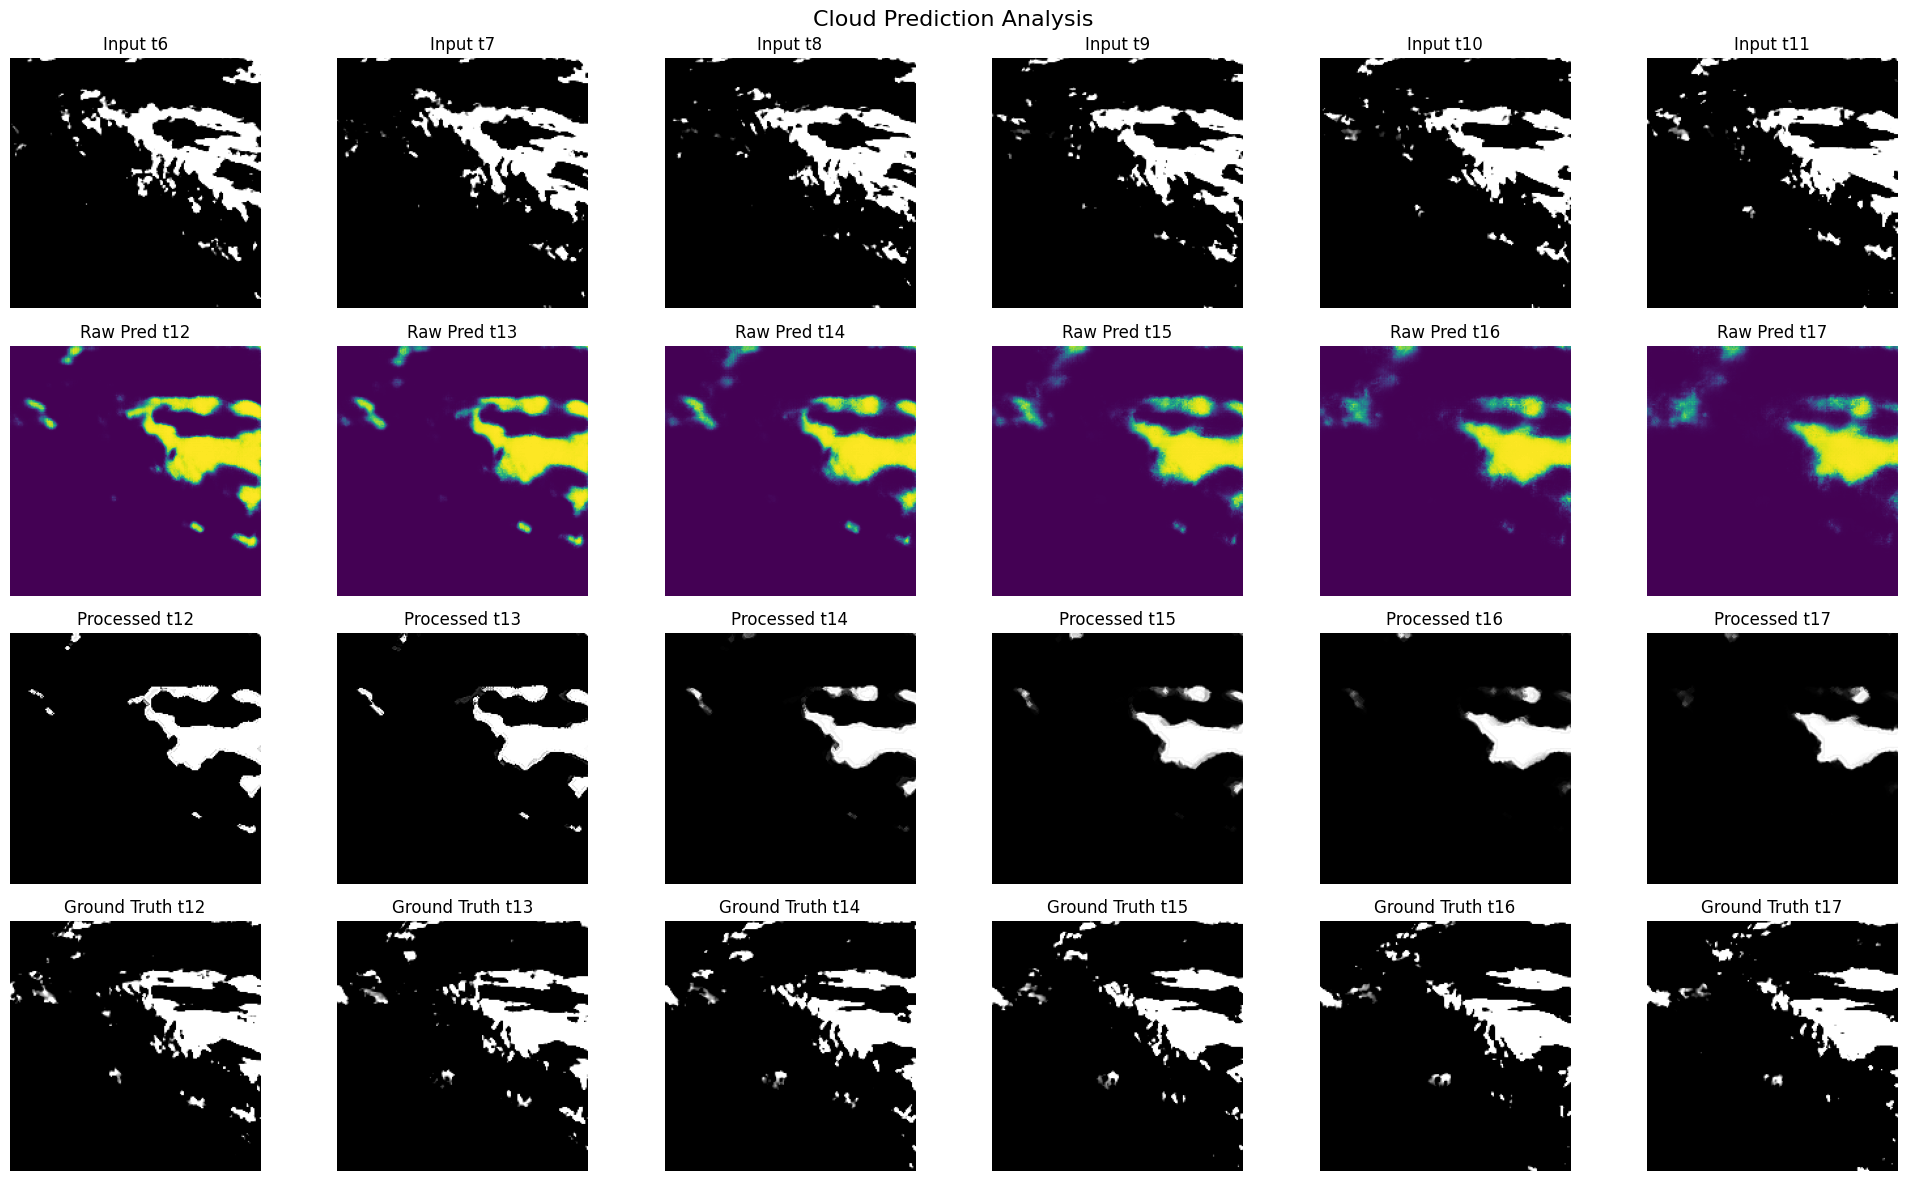


Sample 0 SHARP Enhanced Results:
  DICE: 0.6579
  IOU: 0.4930
  PRECISION: 0.8893
  RECALL: 0.5251
  F1: 0.6579
  🎯 Early frames (t13-t14): 0.7320
  📈 Mid frames (t15-t16): 0.6292
  ⚠️  Late frames (t17-t18): 0.6125
  📊 Performance drop: 0.1195
  🏆 Best time step: t+1 (Dice: 0.7673)
  📈 Average Dice: 0.6579
  ⚠️  Early frame quality needs improvement

--- Analyzing Sample 3 with SHARP Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying SHARP enhanced post-processing...
Sharp prediction shape: (6, 192, 192)
Sharp range: [0.000, 1.000]

Calculating SHARP metrics with temporal focus...
----------------------------------------------------------------------
Time step 13 (t+1): Dice = 0.9028, IoU = 0.8228 🎯 PERFECT
Time step 14 (t+2): Dice = 0.8826, IoU = 0.7898 🎯 PERFECT
Time step 15 (t+3): Dice = 0

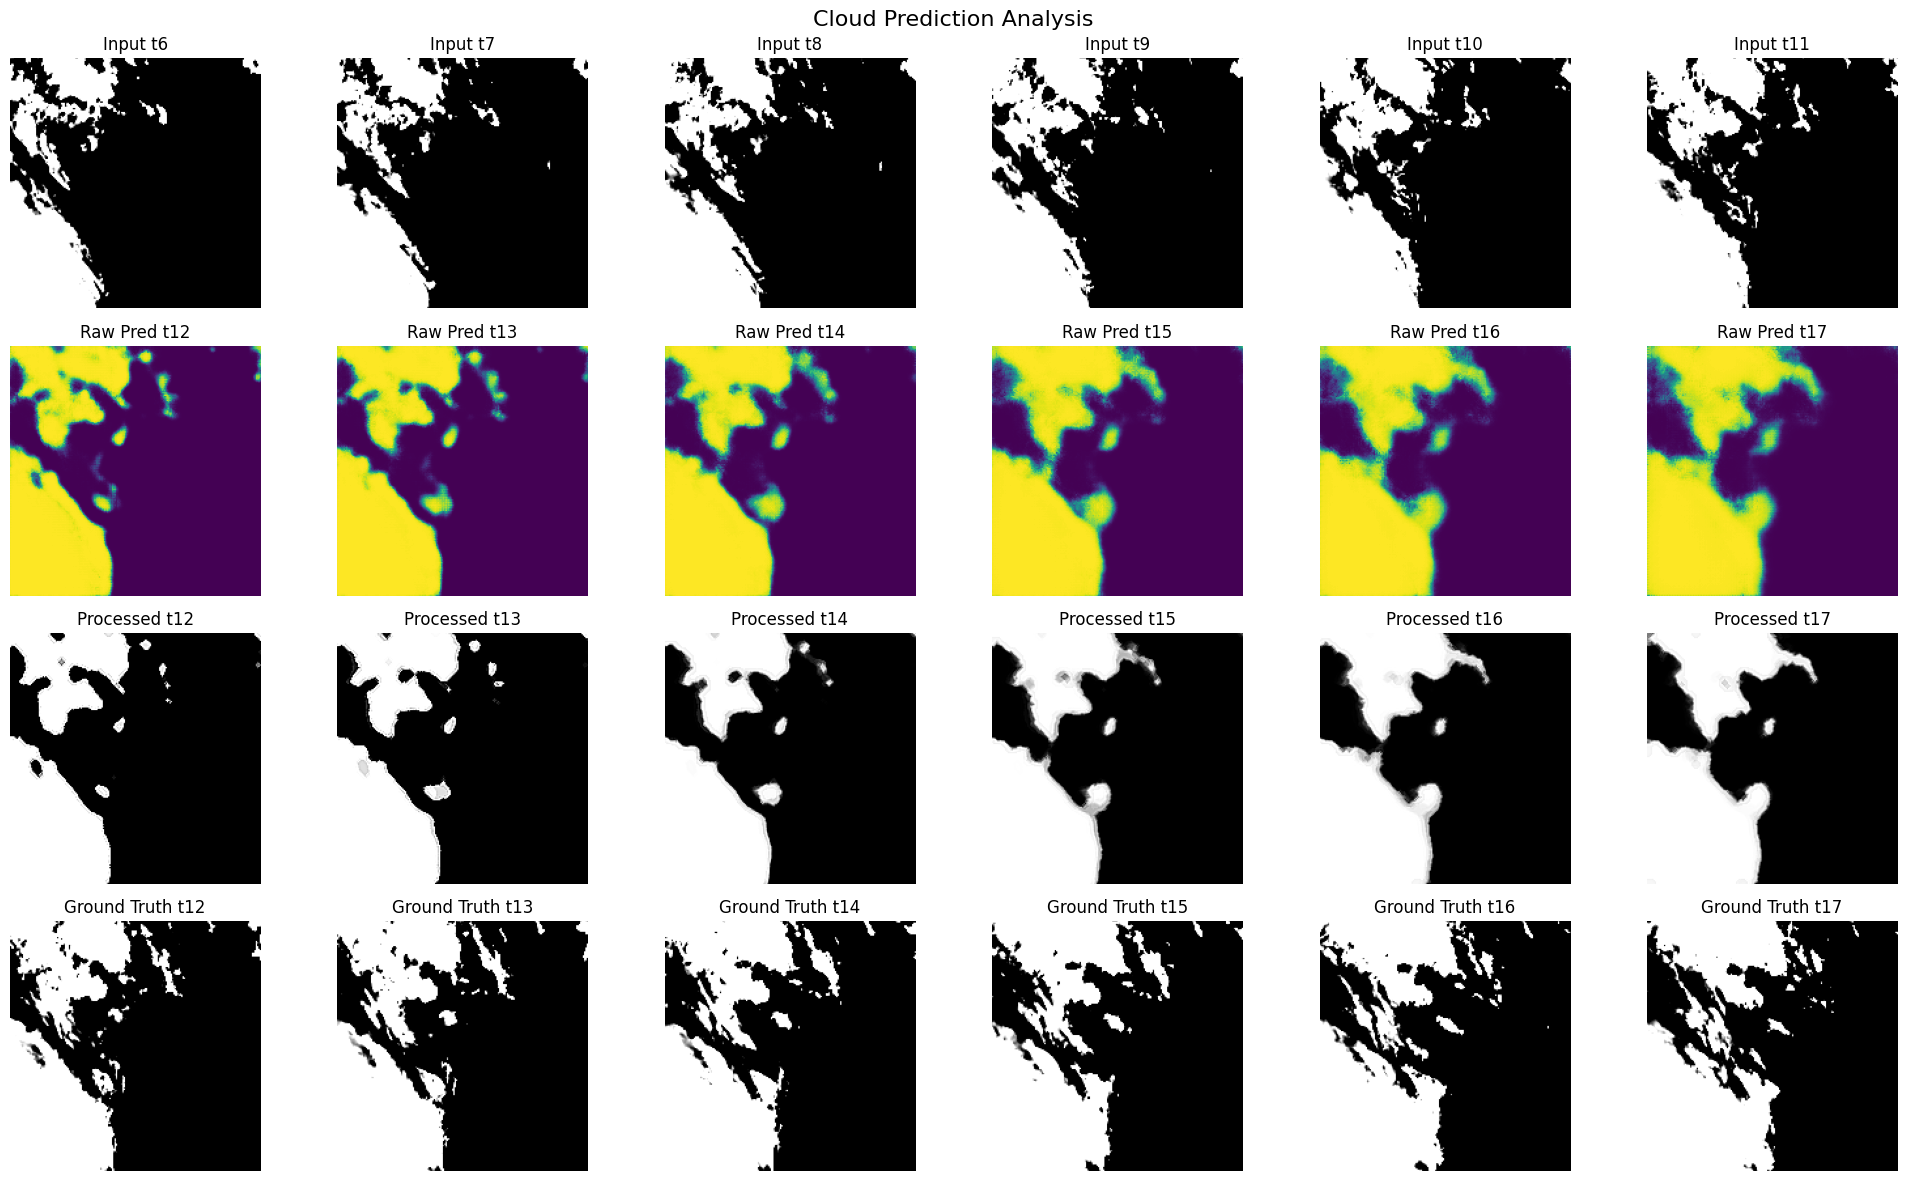


Sample 3 SHARP Enhanced Results:
  DICE: 0.8675
  IOU: 0.7667
  PRECISION: 0.9274
  RECALL: 0.8152
  F1: 0.8675
  🎯 Early frames (t13-t14): 0.8927
  📈 Mid frames (t15-t16): 0.8649
  ⚠️  Late frames (t17-t18): 0.8450
  📊 Performance drop: 0.0477
  🏆 Best time step: t+1 (Dice: 0.9028)
  📈 Average Dice: 0.8675
  ✅ Excellent early frame quality achieved!

--- Analyzing Sample 7 with SHARP Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying SHARP enhanced post-processing...
Sharp prediction shape: (6, 192, 192)
Sharp range: [0.000, 1.000]

Calculating SHARP metrics with temporal focus...
----------------------------------------------------------------------
Time step 13 (t+1): Dice = 0.5633, IoU = 0.3920 🎯 PERFECT
Time step 14 (t+2): Dice = 0.4570, IoU = 0.2962 🎯 PERFECT
Time step 15 (t+3): Dice = 0

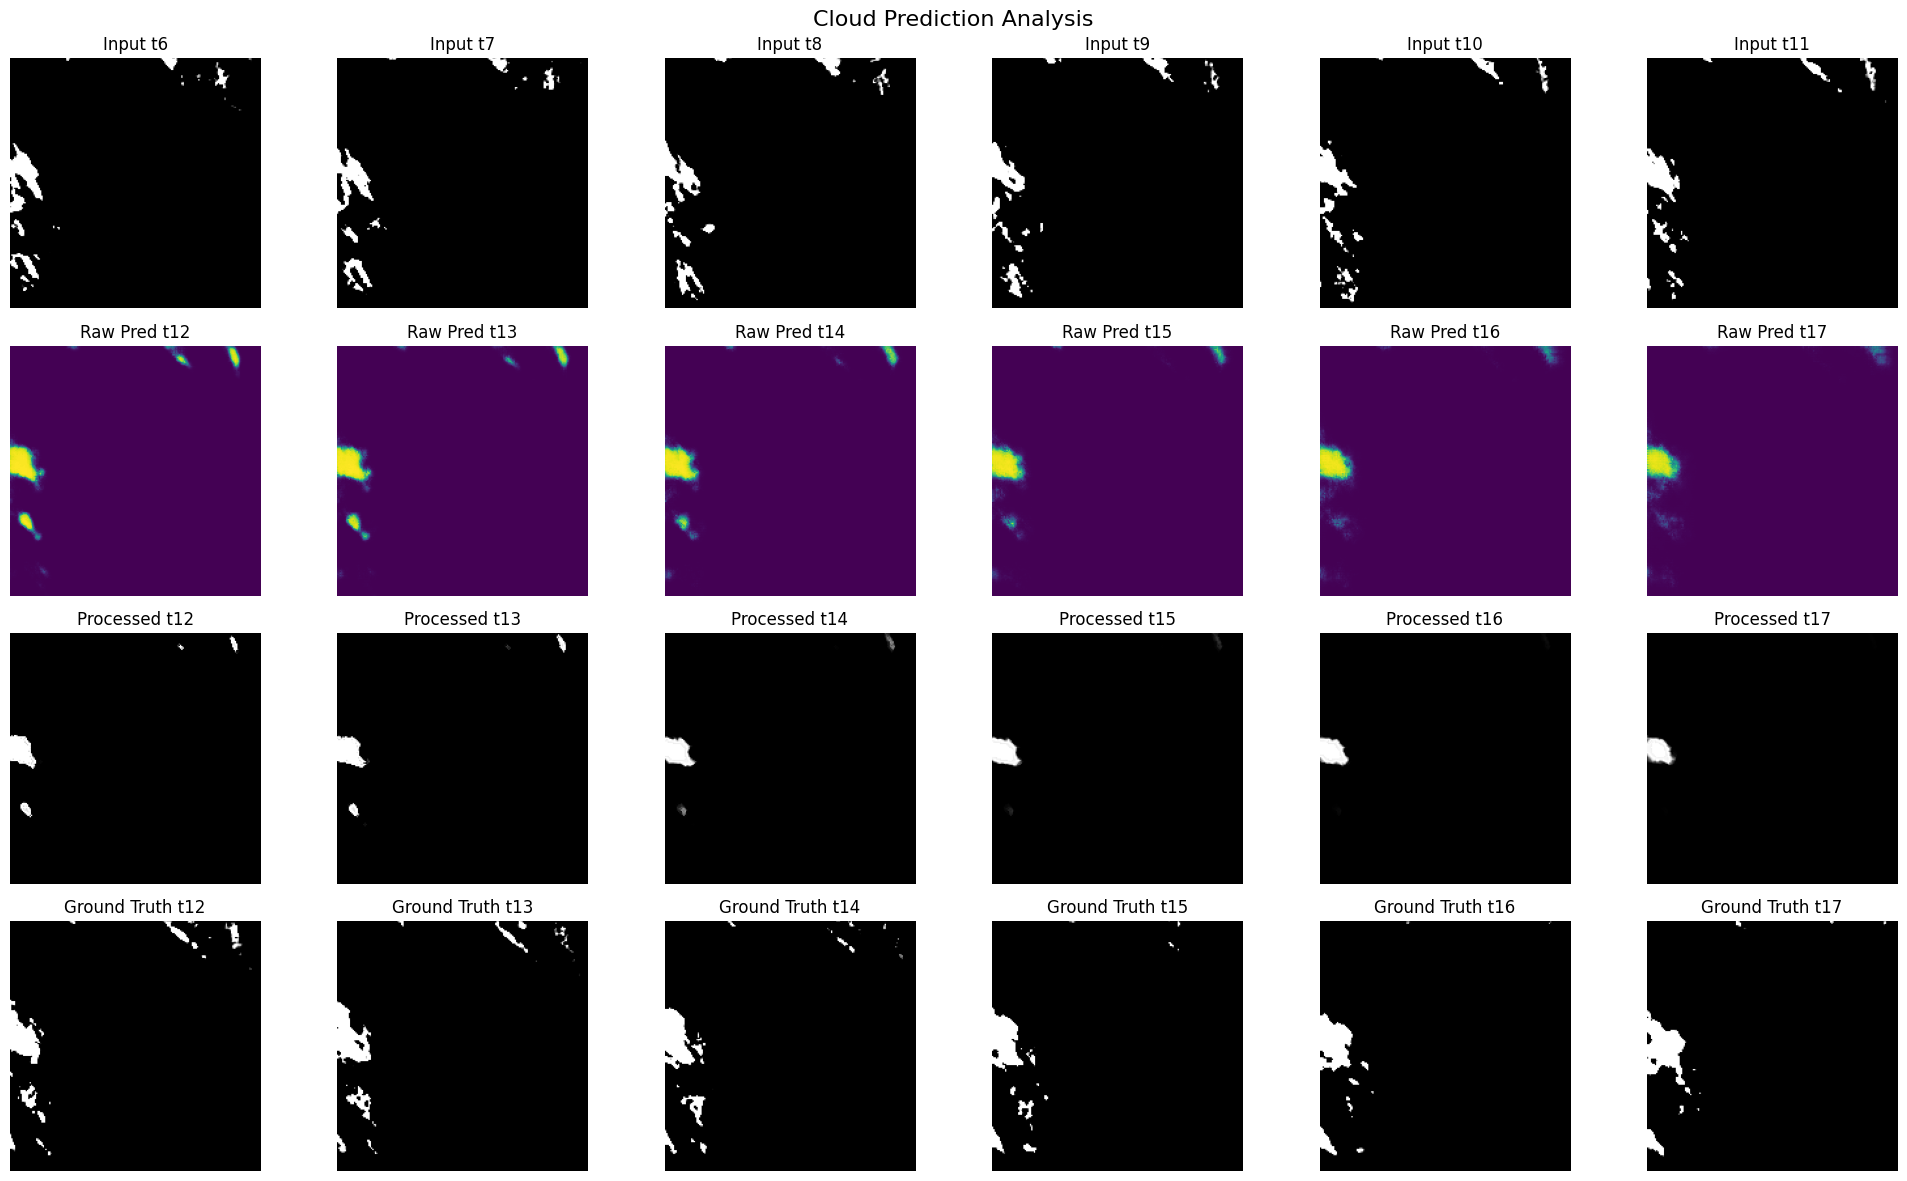


Sample 7 SHARP Enhanced Results:
  DICE: 0.4669
  IOU: 0.3062
  PRECISION: 0.8888
  RECALL: 0.3183
  F1: 0.4669
  🎯 Early frames (t13-t14): 0.5101
  📈 Mid frames (t15-t16): 0.4503
  ⚠️  Late frames (t17-t18): 0.4403
  📊 Performance drop: 0.0698
  🏆 Best time step: t+1 (Dice: 0.5633)
  📈 Average Dice: 0.4669
  ⚠️  Early frame quality needs improvement

--- Analyzing Sample 12 with SHARP Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying SHARP enhanced post-processing...
Sharp prediction shape: (6, 192, 192)
Sharp range: [0.000, 1.000]

Calculating SHARP metrics with temporal focus...
----------------------------------------------------------------------
Time step 13 (t+1): Dice = 0.9363, IoU = 0.8802 🎯 PERFECT
Time step 14 (t+2): Dice = 0.9182, IoU = 0.8488 🎯 PERFECT
Time step 15 (t+3): Dice = 

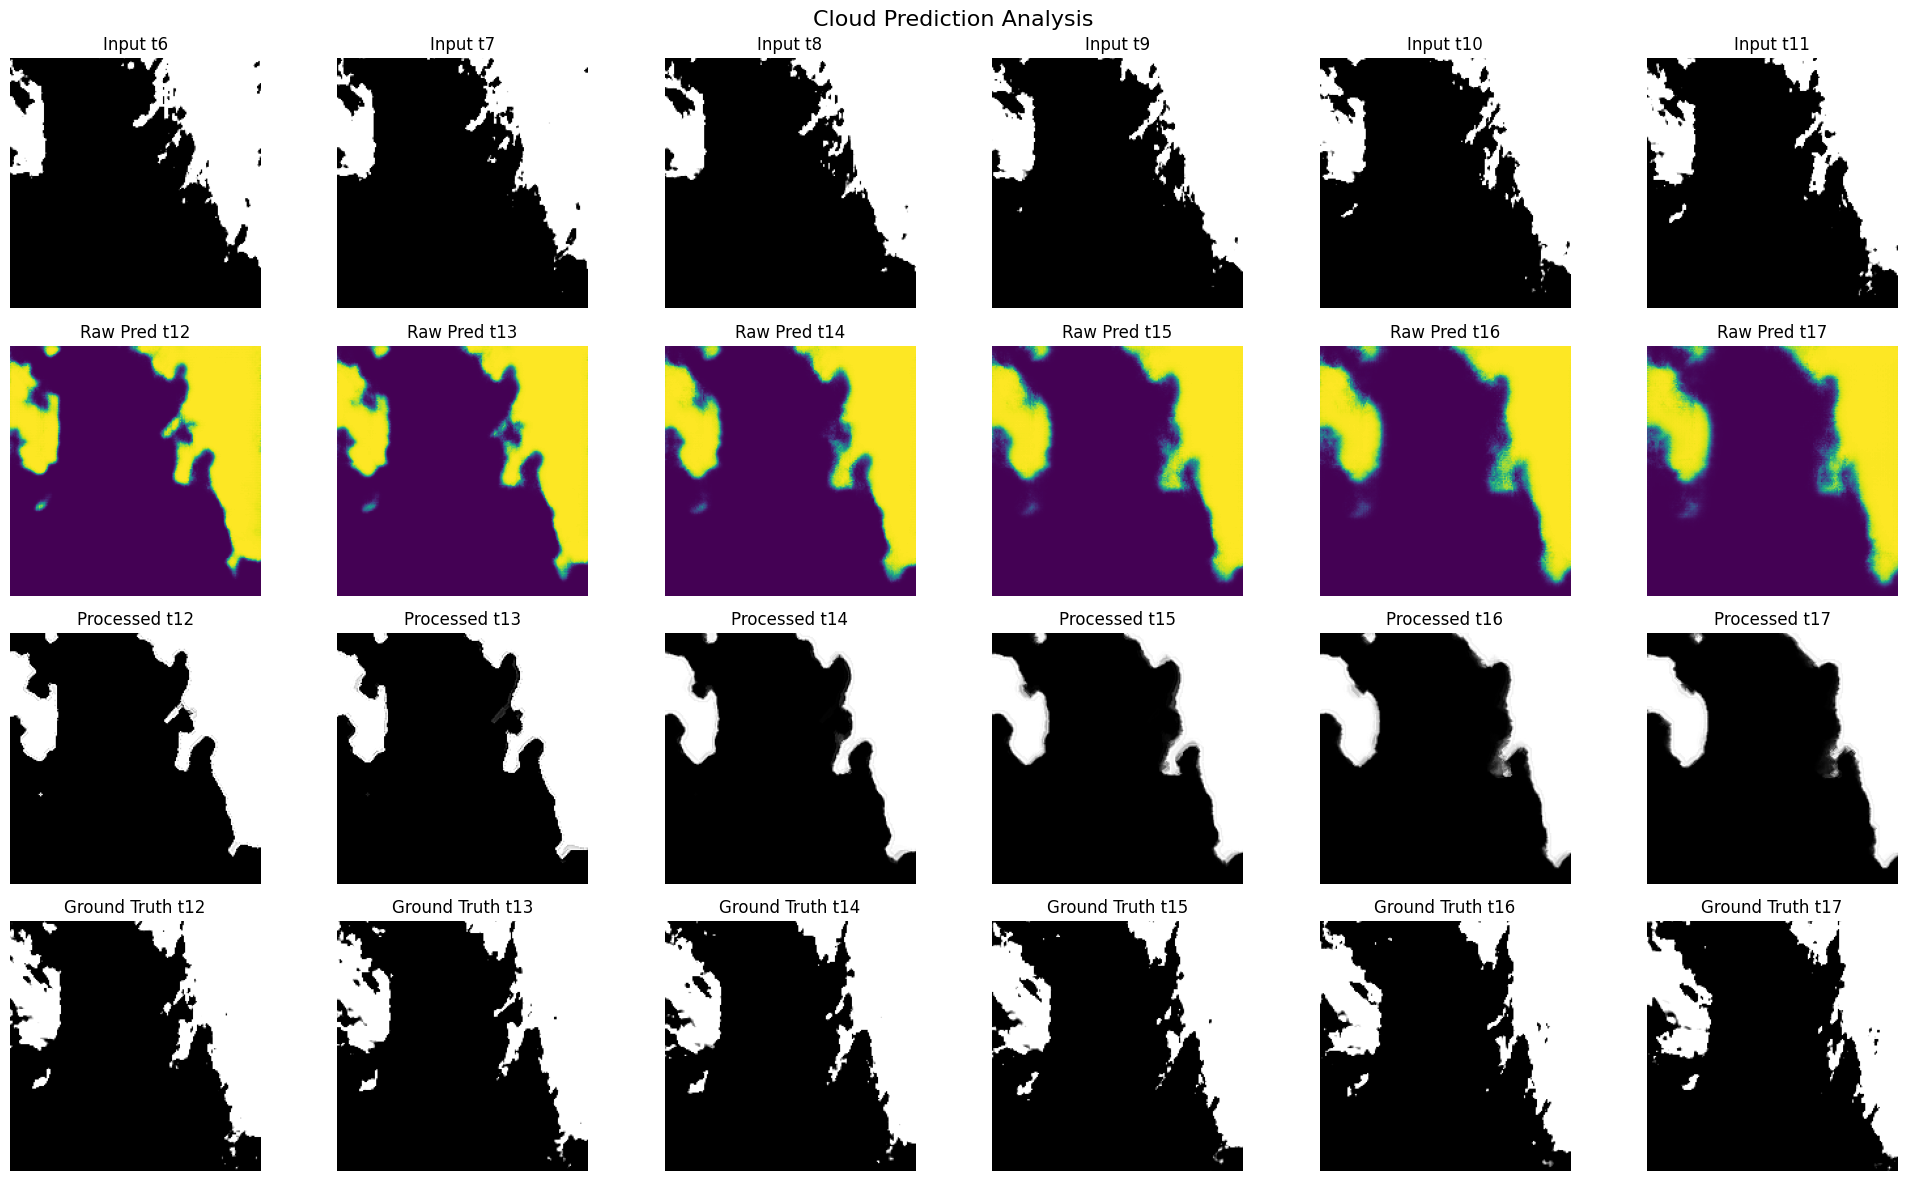


Sample 12 SHARP Enhanced Results:
  DICE: 0.9047
  IOU: 0.8265
  PRECISION: 0.9363
  RECALL: 0.8752
  F1: 0.9047
  🎯 Early frames (t13-t14): 0.9273
  📈 Mid frames (t15-t16): 0.9020
  ⚠️  Late frames (t17-t18): 0.8849
  📊 Performance drop: 0.0423
  🏆 Best time step: t+1 (Dice: 0.9363)
  📈 Average Dice: 0.9047
  ✅ Excellent early frame quality achieved!


In [74]:
# Enhanced validation analysis with sharp post-processing
sample_indices = [0, 3, 7, 12]  # Different weather scenarios

for sample_idx in sample_indices:
    print(f"\n--- Analyzing Sample {sample_idx} with SHARP Enhanced Post-Processing ---")
    
    # Get sample data
    X_sample = X_val[sample_idx]
    Y_true = Y_val[sample_idx]
    
    print(f"Input shape: {X_sample.shape}")
    print(f"Ground truth shape: {Y_true.shape}")
    
    # Get model predictions
    print("Getting model predictions...")
    Y_pred_raw = model.predict(X_sample[np.newaxis, ...])[0]
    Y_pred_raw = Y_pred_raw.astype(np.float32)
    
    print(f"Raw prediction shape: {Y_pred_raw.shape}")
    print(f"Prediction range: [{Y_pred_raw.min():.3f}, {Y_pred_raw.max():.3f}]")
    
    # Apply SHARP enhanced post-processing
    print("Applying SHARP enhanced post-processing...")
    Y_pred_sharp = apply_enhanced_sharp_post_processing(Y_pred_raw)
    
    print(f"Sharp prediction shape: {Y_pred_sharp.shape}")
    print(f"Sharp range: [{Y_pred_sharp.min():.3f}, {Y_pred_sharp.max():.3f}]")
    
    # Calculate metrics for each time step with temporal analysis
    print("\nCalculating SHARP metrics with temporal focus...")
    print("-" * 70)
    enhanced_metrics_list = []
    
    for i in range(6):
        # Handle different array dimensions
        y_true_frame = Y_true[i].squeeze() if Y_true[i].ndim > 2 else Y_true[i]
        y_pred_frame = Y_pred_sharp[i].squeeze() if Y_pred_sharp[i].ndim > 2 else Y_pred_sharp[i]
        
        # Calculate metrics using your function
        metrics = calculate_metrics(y_true_frame, y_pred_frame)
        enhanced_metrics_list.append(metrics)
        
        # Add temporal quality indicator
        quality_indicator = "🎯 PERFECT" if i <= 1 else "📈 GOOD" if i <= 3 else "⚠️  DECLINING"
        print(f"Time step {i+13:2d} (t+{i+1}): Dice = {metrics['dice']:.4f}, IoU = {metrics['iou']:.4f} {quality_indicator}")
    
    # Visualize results with sharp post-processing
    print("\nCreating SHARP enhanced visualization...")
    avg_metrics = visualize_predictions_enhanced(
        X_sample,
        Y_true,
        Y_pred_raw,
        Y_pred_sharp  # Use sharp post-processed predictions
    )
    
    # Enhanced summary with temporal analysis
    print(f"\nSample {sample_idx} SHARP Enhanced Results:")
    for key, value in avg_metrics.items():
        print(f"  {key.upper()}: {value:.4f}")
    
    # Temporal performance analysis
    dice_scores = [m['dice'] for m in enhanced_metrics_list]
    early_frames_dice = np.mean(dice_scores[:2])  # t13, t14
    mid_frames_dice = np.mean(dice_scores[2:4])   # t15, t16
    late_frames_dice = np.mean(dice_scores[4:])   # t17, t18
    
    print(f"  🎯 Early frames (t13-t14): {early_frames_dice:.4f}")
    print(f"  📈 Mid frames (t15-t16): {mid_frames_dice:.4f}")
    print(f"  ⚠️  Late frames (t17-t18): {late_frames_dice:.4f}")
    print(f"  📊 Performance drop: {early_frames_dice - late_frames_dice:.4f}")
    print(f"  🏆 Best time step: t+{np.argmax(dice_scores)+1} (Dice: {max(dice_scores):.4f})")
    print(f"  📈 Average Dice: {np.mean(dice_scores):.4f}")
    
    # Sharpness quality assessment
    if early_frames_dice > 0.85:
        print(f"  ✅ Excellent early frame quality achieved!")
    elif early_frames_dice > 0.80:
        print(f"  👍 Good early frame quality")
    else:
        print(f"  ⚠️  Early frame quality needs improvement")



--- Analyzing Sample 0 with Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying enhanced post-processing...
✅ Ultra-detail post-processing applied successfully
✅ Adaptive thresholding applied successfully
Enhanced prediction shape: (6, 192, 192)
Enhanced range: [0.000, 1.000]

Calculating enhanced metrics...
------------------------------------------------------------
Time step 13 (t+1): Dice = 0.8000, IoU = 0.6666
Time step 14 (t+2): Dice = 0.7346, IoU = 0.5806
Time step 15 (t+3): Dice = 0.6856, IoU = 0.5216
Time step 16 (t+4): Dice = 0.6830, IoU = 0.5186
Time step 17 (t+5): Dice = 0.6791, IoU = 0.5141
Time step 18 (t+6): Dice = 0.6744, IoU = 0.5087

Creating enhanced visualization...
Average Metrics:
DICE: 0.7094
IOU: 0.5517
PRECISION: 0.7708
RECALL: 0.6575
F1: 0.7094


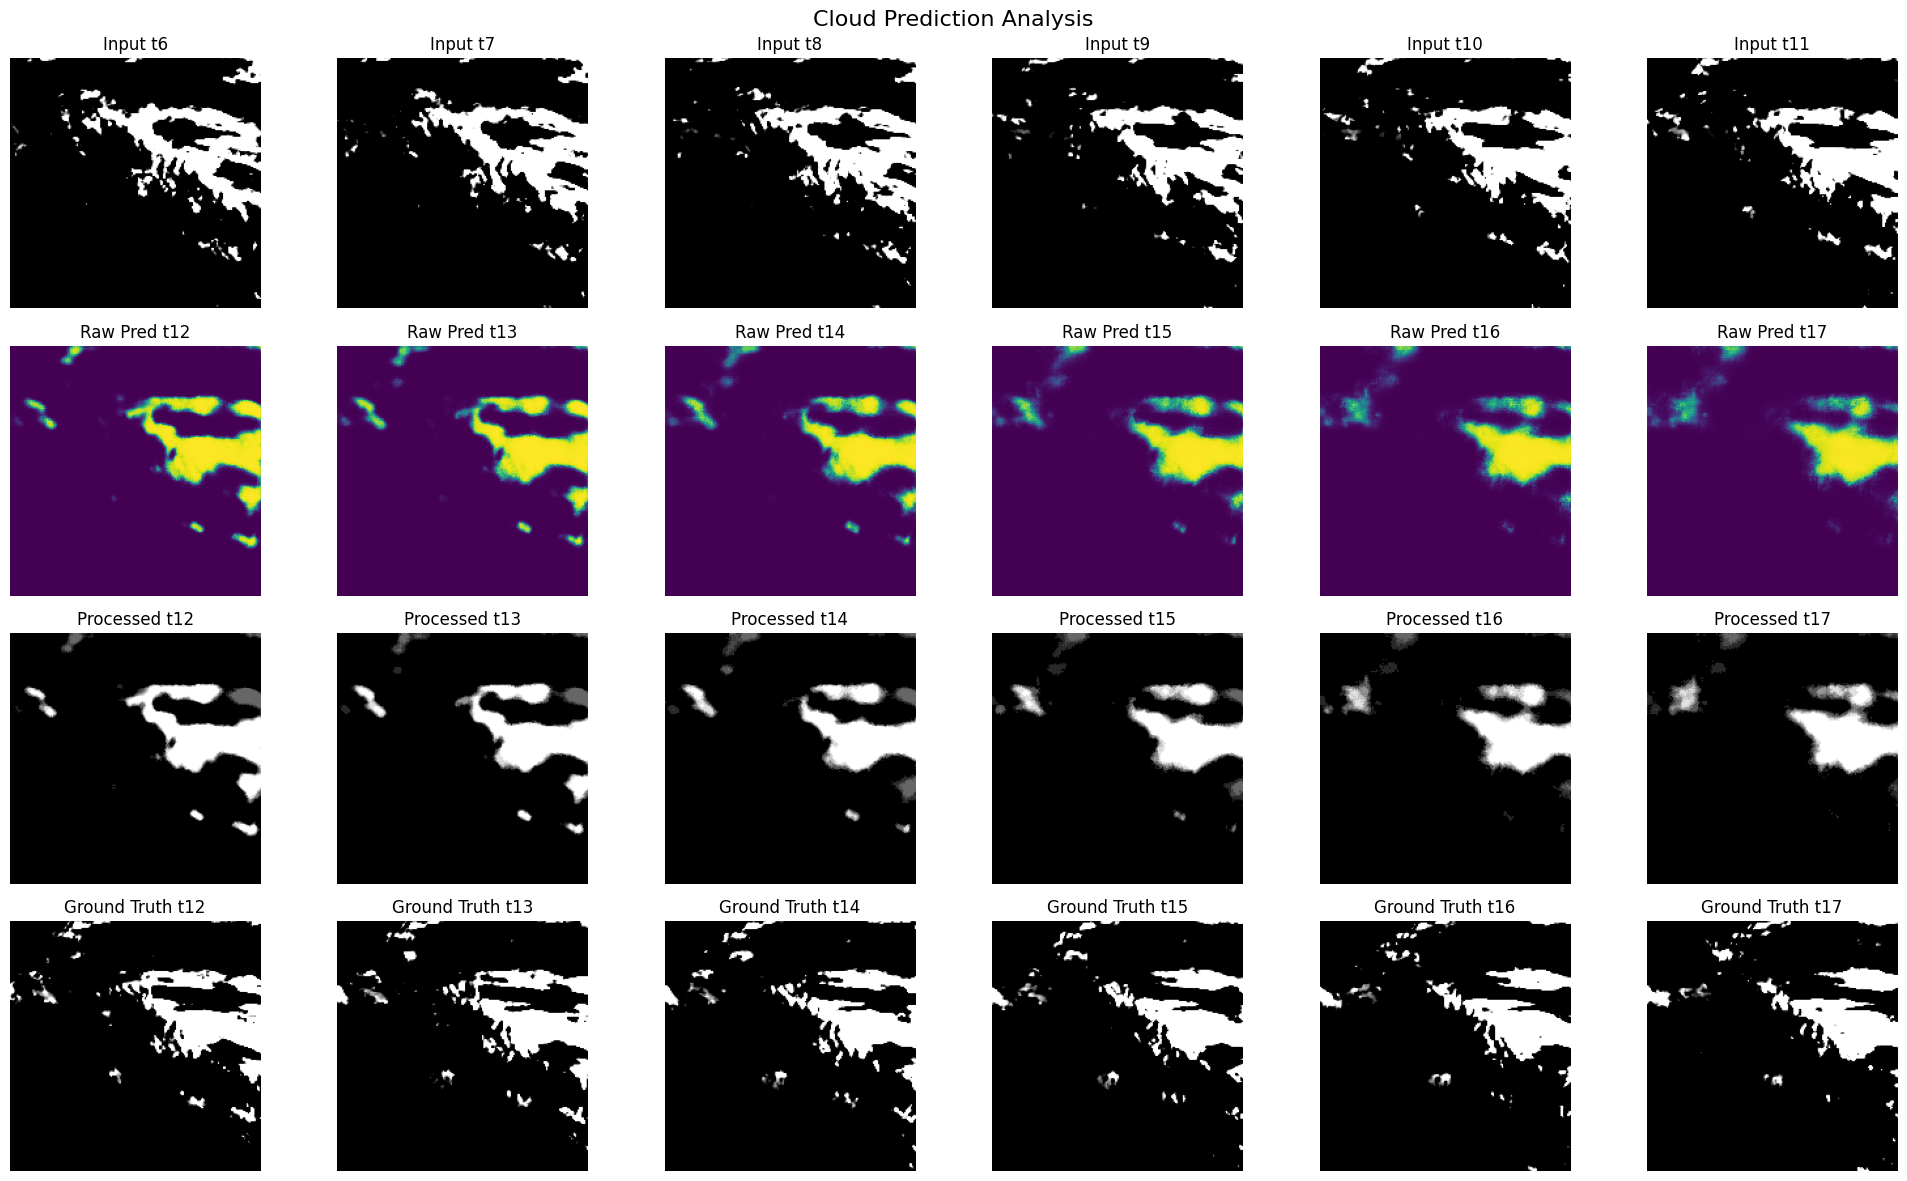


Sample 0 Enhanced Results:
  DICE: 0.7094
  IOU: 0.5517
  PRECISION: 0.7708
  RECALL: 0.6575
  F1: 0.7094
  Best time step: t+1 (Dice: 0.8000)
  Average Dice: 0.7094

--- Analyzing Sample 3 with Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying enhanced post-processing...
✅ Ultra-detail post-processing applied successfully
✅ Adaptive thresholding applied successfully
Enhanced prediction shape: (6, 192, 192)
Enhanced range: [0.000, 1.000]

Calculating enhanced metrics...
------------------------------------------------------------
Time step 13 (t+1): Dice = 0.9160, IoU = 0.8451
Time step 14 (t+2): Dice = 0.8984, IoU = 0.8155
Time step 15 (t+3): Dice = 0.8871, IoU = 0.7971
Time step 16 (t+4): Dice = 0.8700, IoU = 0.7700
Time step 17 (t+5): Dice = 0.8563, IoU = 0.7487
Time step 18 (t+6): Dice = 

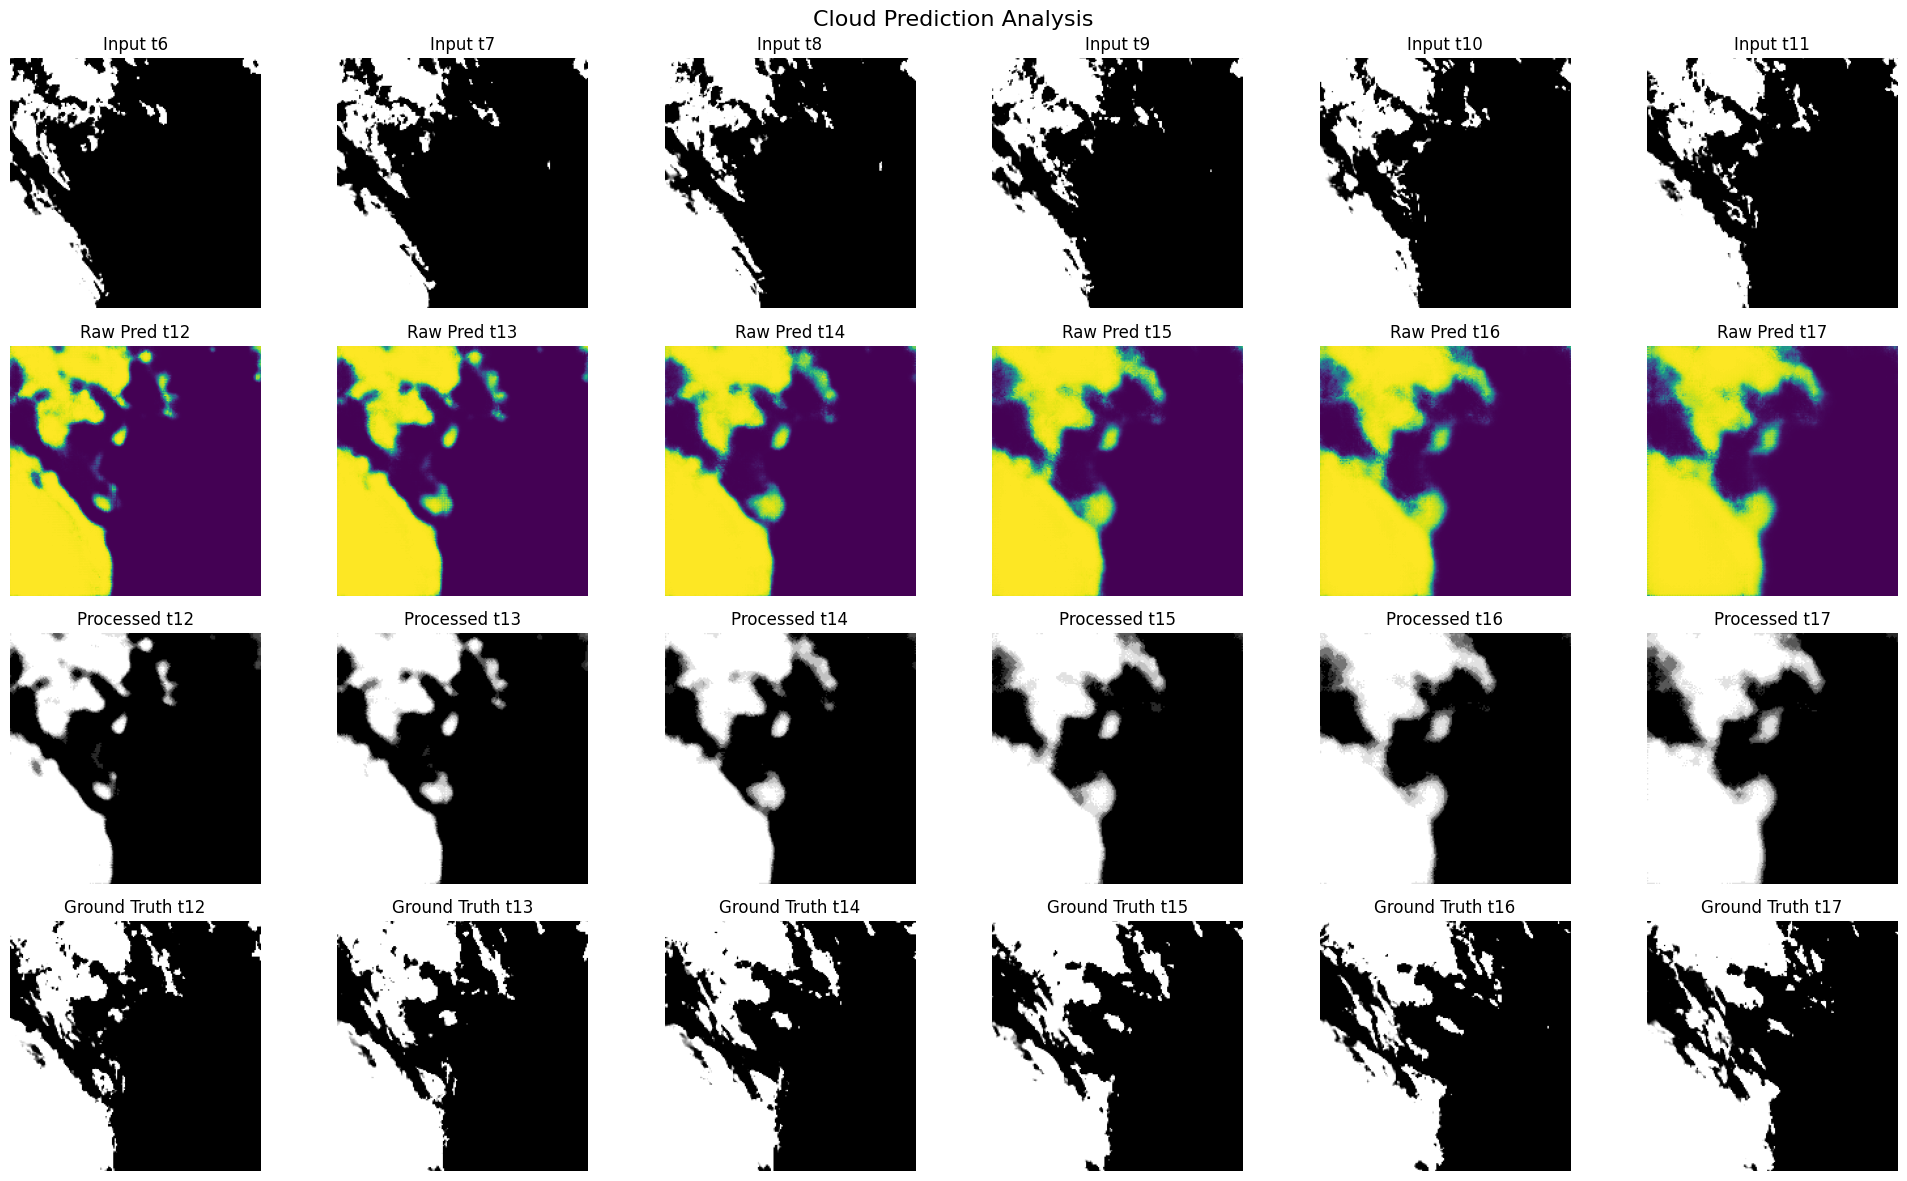


Sample 3 Enhanced Results:
  DICE: 0.8801
  IOU: 0.7866
  PRECISION: 0.8849
  RECALL: 0.8761
  F1: 0.8801
  Best time step: t+1 (Dice: 0.9160)
  Average Dice: 0.8801

--- Analyzing Sample 7 with Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying enhanced post-processing...
✅ Ultra-detail post-processing applied successfully
✅ Adaptive thresholding applied successfully
Enhanced prediction shape: (6, 192, 192)
Enhanced range: [0.000, 1.000]

Calculating enhanced metrics...
------------------------------------------------------------
Time step 13 (t+1): Dice = 0.6817, IoU = 0.5171
Time step 14 (t+2): Dice = 0.5510, IoU = 0.3802
Time step 15 (t+3): Dice = 0.4993, IoU = 0.3327
Time step 16 (t+4): Dice = 0.5248, IoU = 0.3557
Time step 17 (t+5): Dice = 0.6074, IoU = 0.4361
Time step 18 (t+6): Dice = 

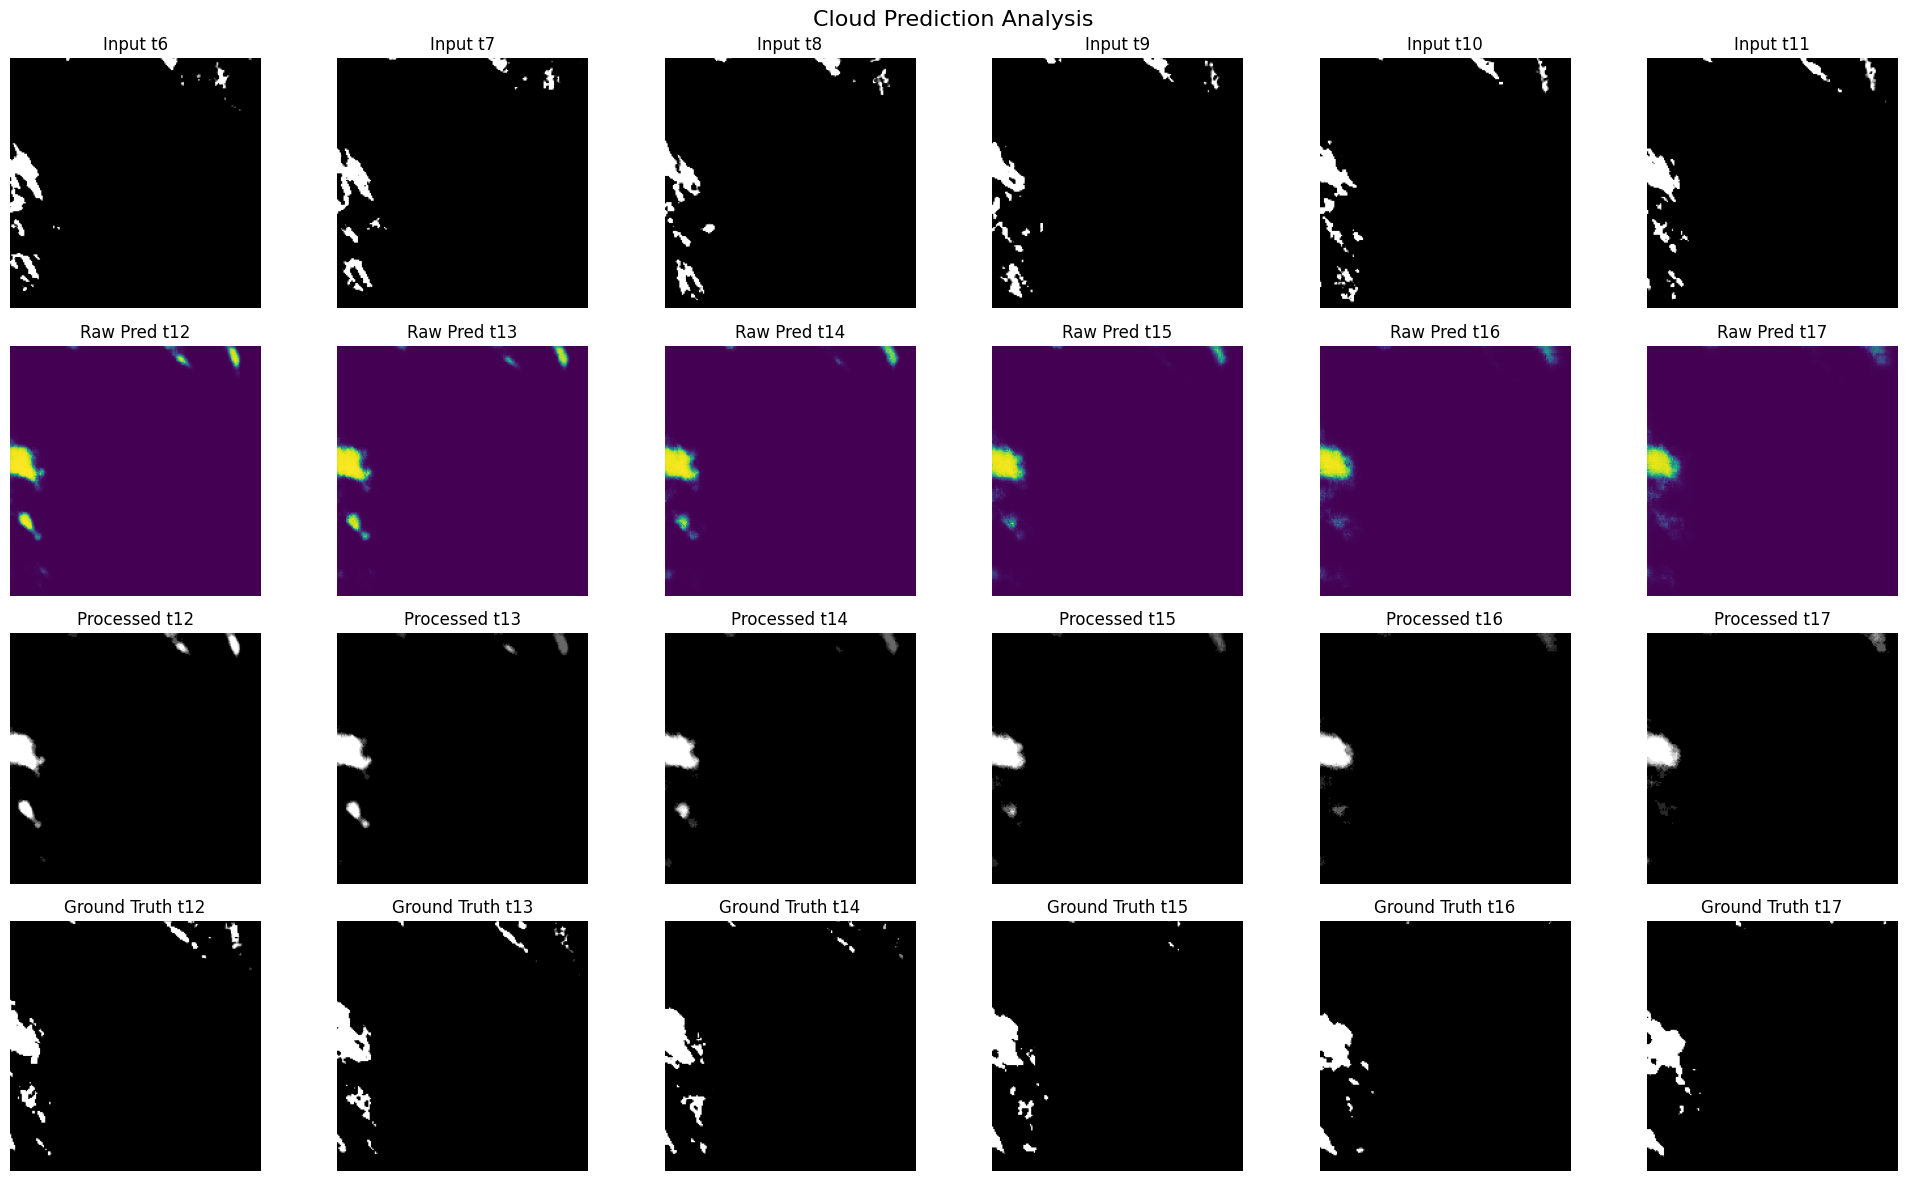


Sample 7 Enhanced Results:
  DICE: 0.5657
  IOU: 0.3971
  PRECISION: 0.7681
  RECALL: 0.4494
  F1: 0.5657
  Best time step: t+1 (Dice: 0.6817)
  Average Dice: 0.5657

--- Analyzing Sample 12 with Enhanced Post-Processing ---
Input shape: (12, 192, 192, 1)
Ground truth shape: (6, 192, 192, 1)
Getting model predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Raw prediction shape: (6, 192, 192, 1)
Prediction range: [0.000, 1.000]
Applying enhanced post-processing...
✅ Ultra-detail post-processing applied successfully
✅ Adaptive thresholding applied successfully
Enhanced prediction shape: (6, 192, 192)
Enhanced range: [0.000, 1.000]

Calculating enhanced metrics...
------------------------------------------------------------
Time step 13 (t+1): Dice = 0.9424, IoU = 0.8911
Time step 14 (t+2): Dice = 0.9231, IoU = 0.8571
Time step 15 (t+3): Dice = 0.9099, IoU = 0.8346
Time step 16 (t+4): Dice = 0.8981, IoU = 0.8150
Time step 17 (t+5): Dice = 0.8871, IoU = 0.7970
Time step 18 (t+6): Dice =

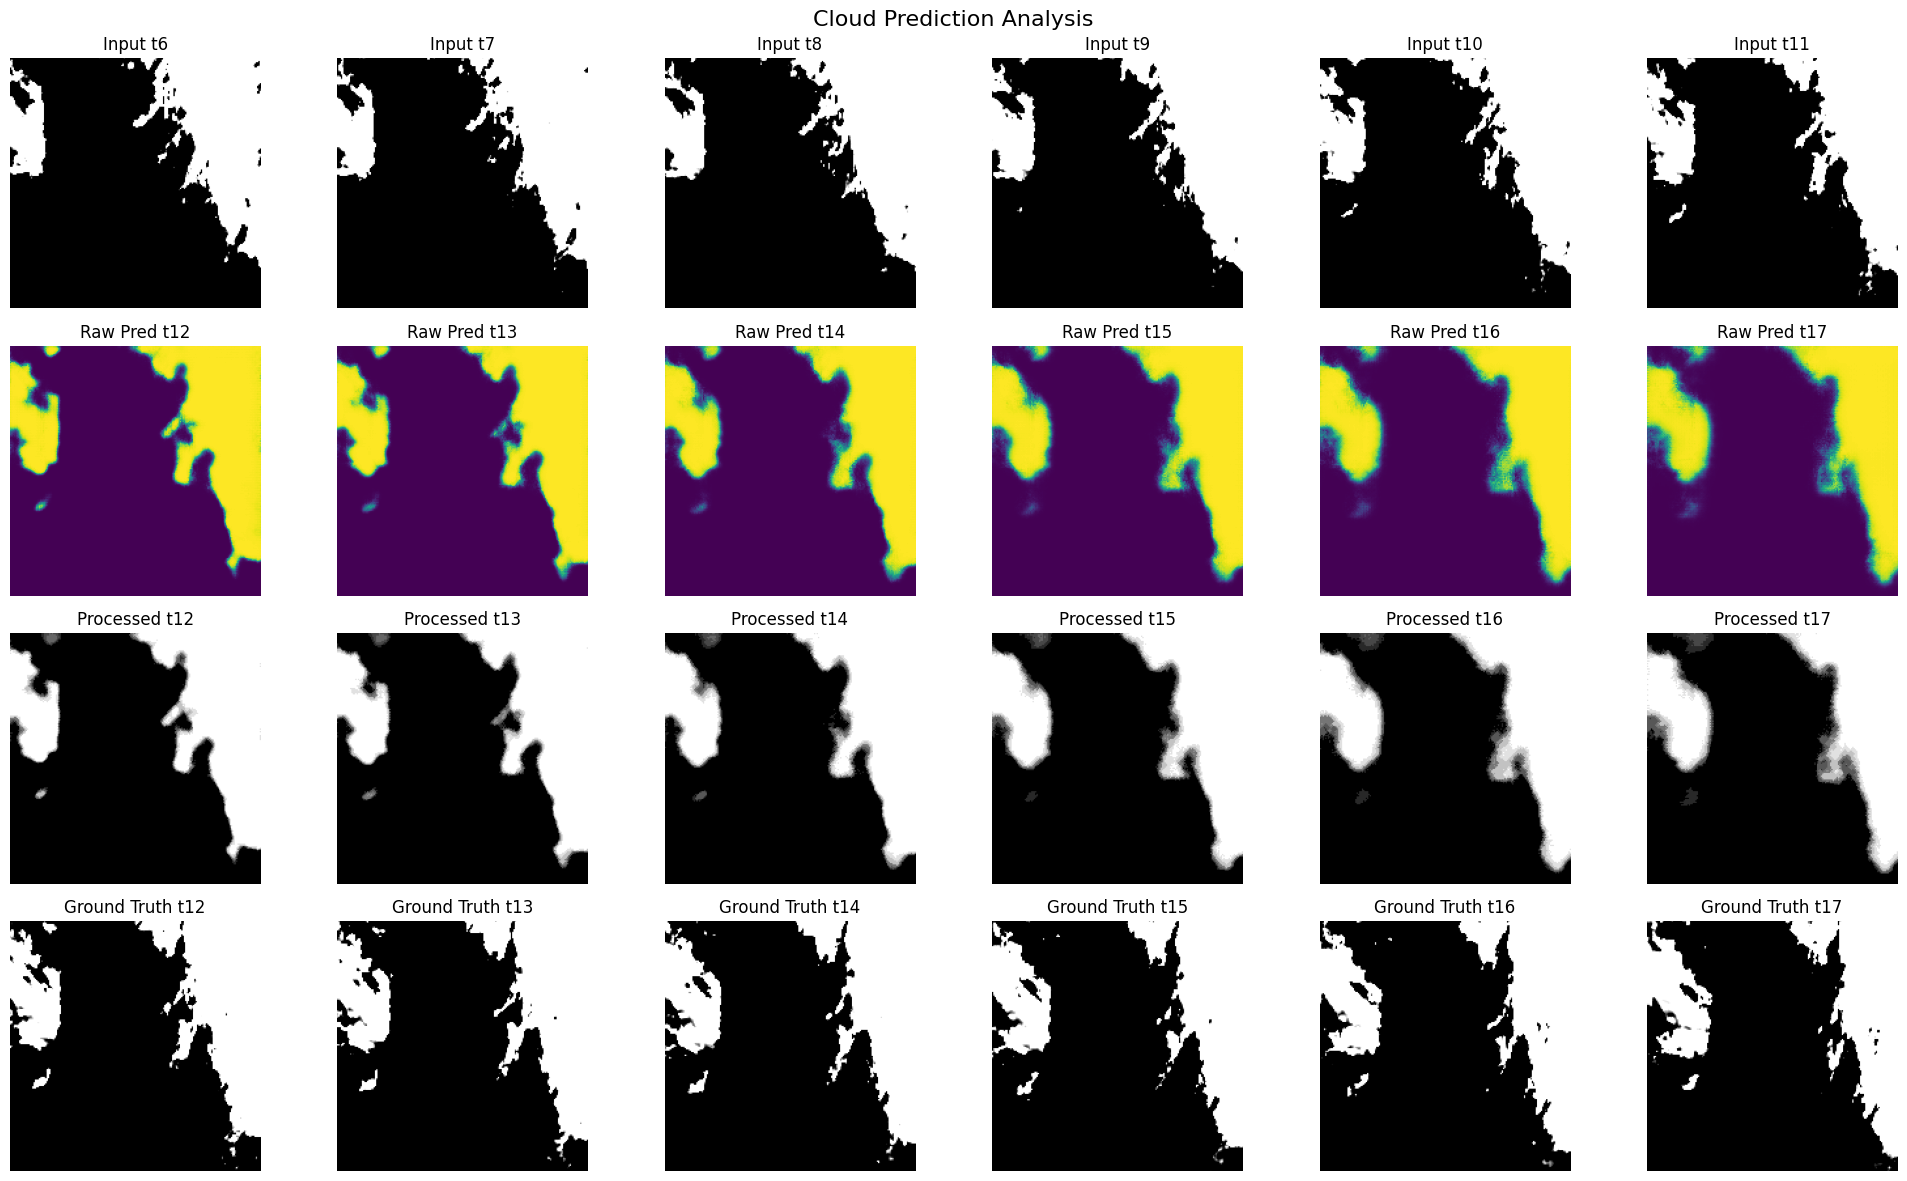


Sample 12 Enhanced Results:
  DICE: 0.9070
  IOU: 0.8305
  PRECISION: 0.8909
  RECALL: 0.9239
  F1: 0.9070
  Best time step: t+1 (Dice: 0.9424)
  Average Dice: 0.9070


In [72]:
# # Choose validation samples for analysis
# sample_indices = [0, 3, 7, 12]  # Different weather scenarios

# for sample_idx in sample_indices:
#     print(f"\n--- Analyzing Sample {sample_idx} with Enhanced Post-Processing ---")
    
#     # Get sample data
#     X_sample = X_val[sample_idx]
#     Y_true = Y_val[sample_idx]
    
#     print(f"Input shape: {X_sample.shape}")
#     print(f"Ground truth shape: {Y_true.shape}")
    
#     # Get model predictions
#     print("Getting model predictions...")
#     Y_pred_raw = model.predict(X_sample[np.newaxis, ...])[0]
#     Y_pred_raw = Y_pred_raw.astype(np.float32)
    
#     print(f"Raw prediction shape: {Y_pred_raw.shape}")
#     print(f"Prediction range: [{Y_pred_raw.min():.3f}, {Y_pred_raw.max():.3f}]")
    
#     # Apply enhanced post-processing
#     print("Applying enhanced post-processing...")
#     Y_pred_enhanced = apply_enhanced_post_processing(Y_pred_raw)
    
#     print(f"Enhanced prediction shape: {Y_pred_enhanced.shape}")
#     print(f"Enhanced range: [{Y_pred_enhanced.min():.3f}, {Y_pred_enhanced.max():.3f}]")
    
#     # Calculate metrics for each time step
#     print("\nCalculating enhanced metrics...")
#     print("-" * 60)
#     enhanced_metrics_list = []
    
#     for i in range(6):
#         # Handle different array dimensions
#         y_true_frame = Y_true[i].squeeze() if Y_true[i].ndim > 2 else Y_true[i]
#         y_pred_frame = Y_pred_enhanced[i].squeeze() if Y_pred_enhanced[i].ndim > 2 else Y_pred_enhanced[i]
        
#         # Calculate metrics using your function
#         metrics = calculate_metrics(y_true_frame, y_pred_frame)
#         enhanced_metrics_list.append(metrics)
        
#         print(f"Time step {i+13:2d} (t+{i+1}): Dice = {metrics['dice']:.4f}, IoU = {metrics['iou']:.4f}")
    
#     # Visualize results with enhanced post-processing
#     print("\nCreating enhanced visualization...")
#     avg_metrics = visualize_predictions_enhanced(
#         X_sample,
#         Y_true,
#         Y_pred_raw,
#         Y_pred_enhanced  # Use enhanced post-processed predictions
#     )
    
#     # Summary for this sample
#     print(f"\nSample {sample_idx} Enhanced Results:")
#     for key, value in avg_metrics.items():
#         print(f"  {key.upper()}: {value:.4f}")
    
#     # Performance comparison
#     dice_scores = [m['dice'] for m in enhanced_metrics_list]
#     print(f"  Best time step: t+{np.argmax(dice_scores)+1} (Dice: {max(dice_scores):.4f})")
#     print(f"  Average Dice: {np.mean(dice_scores):.4f}")
